Imports

In [1]:
import random

import numpy as np
import torch
from torch import optim
from tqdm import tqdm

import gymnasium as gym

from stable_baselines3 import A2C,PPO


from stable_baselines3.common.logger import configure


import fabian.envs.khazad_dum_gymn 

import matplotlib.pyplot as plt

import pickle

## Working with 26May_TestingPseudoRoML_A2C_3a_MAML

Load in returns generated from the final form of this model

In [2]:
model_save_path = "C:\\Users\\fabia\\Documents\\GitHub\\MetaStableBaselines3\\proj_code\\saved_models\\27May_MAML_A2C_KDcont3_ep64"

dbfile = open(f"{model_save_path}\\iidReturnList.pickle", 'rb')
return_list = pickle.load(dbfile)

dbfile = open(f"{model_save_path}\\TaskwiseReturns.pickle", 'rb')
returns=pickle.load(dbfile) 

In [3]:
print(len(return_list))
print(len(returns.keys()))

100001
200


Load in the model too, to have access to the SMC functions of it

In [4]:
import fabian.envs.khazad_dum_gymn 
env = gym.make("KhazadDum-v1", continuous=True,  max_speed=0.5, max_episode_steps=64) # can access wrapped env with "env.unwrapped" (e.g. to reset task)
env.unwrapped.exp_bonus = 1; env.unwrapped.bridge_bonus_factor = 2 #this should incentivise getting to the target asap, and incentivise going onto the bridge


meta_agent = A2C("MlpPolicy", env, verbose=0, learning_rate=7e-4, device="cpu",
                 meta_learning=True, M=1, adapt_timesteps=4*32, eval_timesteps=2*32)
meta_agent.policy.load_state_dict(torch.load(f"{model_save_path}\\final", weights_only=True))

c:\Users\fabia\anaconda3\envs\projdist\Lib\site-packages\gymnasium\envs\registration.py:487: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


<All keys matched successfully>

Histogram of i.i.d. returns

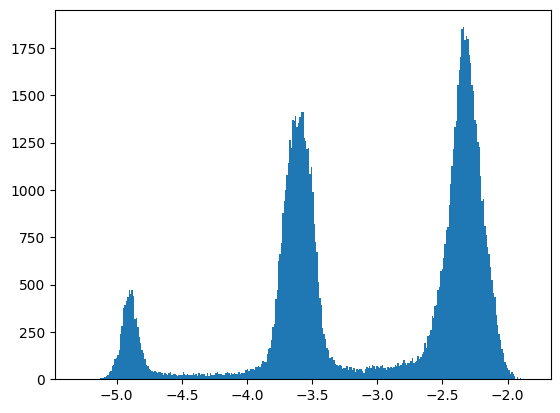

In [6]:
plt.hist([i[0] for i in return_list], bins="sqrt")
plt.show()

Theorem 1

In [7]:
return_list_sorted = sorted(return_list)

In [8]:
eta=0.001
k=int(len(return_list_sorted)*0.05)

epsilon, guarantee =  meta_agent.rollout_risk_SMC(eta, k, return_list_sorted)
print((epsilon, guarantee))


(array([0.05216458]), [tensor(-4.8572)])


In [9]:
len(return_list_sorted)//1000

100

In [10]:
#Tracking what PAC guarantee we get from T1 with k=0 as n increases - we expect both epsilon and J to eventually converge to some value,but how quickly?
#and then, we wanna compare for differnet ks, and compare to a 'true' risk for the stated performance gaurantee at each level
eta = 0.001

k=0

ns = []
t1_epsilon_k0_againstn = []
t1_guarantee_k0_againstn = []
for n in tqdm(range(100,len(return_list), 1000)):
    epsilon, guarantee = meta_agent.rollout_risk_SMC(eta, k, return_list[:n])

    ns.append(n)
    t1_epsilon_k0_againstn.append(epsilon)
    t1_guarantee_k0_againstn.append(guarantee)

100%|██████████| 100/100 [06:26<00:00,  3.87s/it]


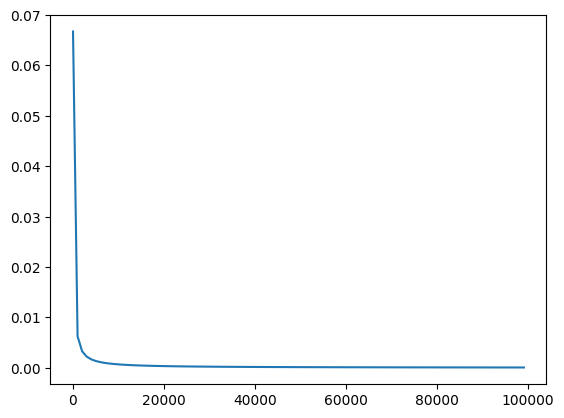

In [11]:
plt.plot(ns, t1_epsilon_k0_againstn)
plt.show()


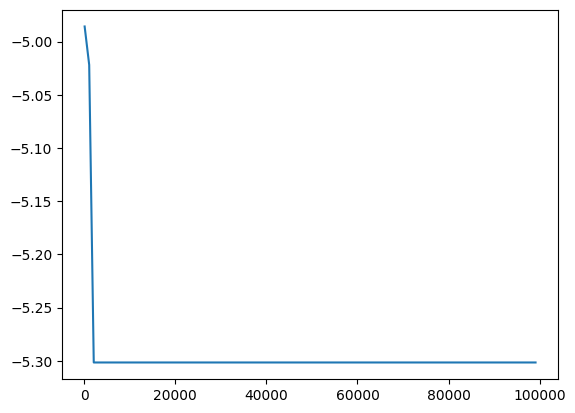

In [12]:
plt.plot(ns, t1_guarantee_k0_againstn)
plt.show()

In [13]:
[i for i in range(0, len(return_list), 20_000)]

[0, 20000, 40000, 60000, 80000, 100000]

# CHECK OUT THESE RESULTS BELOW!

In [14]:
#Tracking what PAC guarantee we get from T1 with k=0 as n increases - we expect both epsilon and J to eventually converge to some value,but how quickly?
#and then, we wanna compare for differnet ks, and compare to a 'true' risk for the stated performance gaurantee at each level
eta = 0.001

kprop=0.00

#epsilon pretty much converged at 20K trials, so lets batch this up and do 5 trials as 'repeats'
return_chunks = [return_list[0:20_000],
                 return_list[20_000:40_000],
                 return_list[40_000:60_000],
                 return_list[60_000:80_000],
                 return_list[80_000:100_000]]

ns = [i for i in range(10,len(return_chunks[0]), 500)]
kprop0_epsilons_byn_bychunk = []
kprop0_guarantees_byn_bychunk = []

for return_chunk in return_chunks:
    kprop0_epsilons_byn = []
    kprop0_guarantees_byn = []
    for n in tqdm(ns):
        k=int(kprop*n)
        epsilon, guarantee = meta_agent.rollout_risk_SMC(eta, k, return_chunk[:n])
        
        kprop0_epsilons_byn.append(epsilon)
        kprop0_guarantees_byn.append(guarantee)
    
    kprop0_epsilons_byn_bychunk.append(kprop0_epsilons_byn)
    kprop0_guarantees_byn_bychunk.append(kprop0_guarantees_byn)



100%|██████████| 40/40 [00:23<00:00,  1.74it/s]


In [15]:
#Tracking what PAC guarantee we get from T1 with k=0 as n increases - we expect both epsilon and J to eventually converge to some value,but how quickly?
#and then, we wanna compare for differnet ks, and compare to a 'true' risk for the stated performance gaurantee at each level
eta = 0.001

kprop=0.001

#epsilon pretty much converged at 20K trials, so lets batch this up and do 5 trials as 'repeats'
return_chunks = [return_list[0:20_000],
                 return_list[20_000:40_000],
                 return_list[40_000:60_000],
                 return_list[60_000:80_000],
                 return_list[80_000:100_000]]

ns = [i for i in range(10,len(return_chunks[0]), 500)]
kprop001_epsilons_byn_bychunk = []
kprop001_guarantees_byn_bychunk = []

for return_chunk in return_chunks:
    kprop0_epsilons_byn = []
    kprop0_guarantees_byn = []
    for n in tqdm(ns):
        k=int(kprop*n)
        epsilon, guarantee = meta_agent.rollout_risk_SMC(eta, k, return_chunk[:n])
        
        kprop0_epsilons_byn.append(epsilon)
        kprop0_guarantees_byn.append(guarantee)
    
    kprop001_epsilons_byn_bychunk.append(kprop0_epsilons_byn)
    kprop001_guarantees_byn_bychunk.append(kprop0_guarantees_byn)

100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


In [16]:
#Tracking what PAC guarantee we get from T1 with k=0 as n increases - we expect both epsilon and J to eventually converge to some value,but how quickly?
#and then, we wanna compare for differnet ks, and compare to a 'true' risk for the stated performance gaurantee at each level
eta = 0.001

kprop=0.01

#epsilon pretty much converged at 20K trials, so lets batch this up and do 5 trials as 'repeats'
return_chunks = [return_list[0:20_000],
                 return_list[20_000:40_000],
                 return_list[40_000:60_000],
                 return_list[60_000:80_000],
                 return_list[80_000:100_000]]

ns = [i for i in range(10,len(return_chunks[0]), 500)]
kprop01_epsilons_byn_bychunk = []
kprop01_guarantees_byn_bychunk = []

for return_chunk in return_chunks:
    kprop0_epsilons_byn = []
    kprop0_guarantees_byn = []
    for n in tqdm(ns):
        k=int(kprop*n)
        epsilon, guarantee = meta_agent.rollout_risk_SMC(eta, k, return_chunk[:n])
        
        kprop0_epsilons_byn.append(epsilon)
        kprop0_guarantees_byn.append(guarantee)
    
    kprop01_epsilons_byn_bychunk.append(kprop0_epsilons_byn)
    kprop01_guarantees_byn_bychunk.append(kprop0_guarantees_byn)

100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


In [17]:
#Tracking what PAC guarantee we get from T1 with k=0 as n increases - we expect both epsilon and J to eventually converge to some value,but how quickly?
#and then, we wanna compare for differnet ks, and compare to a 'true' risk for the stated performance gaurantee at each level
eta = 0.001

kprop=0.05

#epsilon pretty much converged at 20K trials, so lets batch this up and do 5 trials as 'repeats'
return_chunks = [return_list[0:20_000],
                 return_list[20_000:40_000],
                 return_list[40_000:60_000],
                 return_list[60_000:80_000],
                 return_list[80_000:100_000]]

ns = [i for i in range(10,len(return_chunks[0]), 500)]
kprop05_epsilons_byn_bychunk = []
kprop05_guarantees_byn_bychunk = []

for return_chunk in return_chunks:
    kprop0_epsilons_byn = []
    kprop0_guarantees_byn = []
    for n in tqdm(ns):
        k=int(kprop*n)
        epsilon, guarantee = meta_agent.rollout_risk_SMC(eta, k, return_chunk[:n])
        
        kprop0_epsilons_byn.append(epsilon)
        kprop0_guarantees_byn.append(guarantee)
    
    kprop05_epsilons_byn_bychunk.append(kprop0_epsilons_byn)
    kprop05_guarantees_byn_bychunk.append(kprop0_guarantees_byn)

100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


In [18]:
def plotCIs(xs, y_seriess, label, ax, colour, linestyle="solid"):
    mins = []
    means = []
    maxs = []
    for i in range(len(y_seriess[0])):
        vals = [y_series[i] for y_series in y_seriess]
        means.append(np.mean(vals))
        std = np.std(vals)
        mins.append(means[i]-2*std) #doing 2*ci for bounds rather than CIs so dont need to assume niormality
        maxs.append(means[i]+2*std)
    
    ax.plot(xs, means, color=colour, label=label, linestyle=linestyle)
    ax.fill_between(xs, mins, maxs, color=colour, alpha=0.2)

In [19]:
kprop0_empiricalEpsilons_byn_bychunks = []
for guarantees_byn in kprop0_guarantees_byn_bychunk:
    empiricalEpsilons = []
    for guarantee in tqdm(guarantees_byn):
        #Find proportion of returns in {return_list} < guarantee
        empiricalEpsilons.append(sum(1 for g in return_list if g<guarantee)/len(return_list))
    kprop0_empiricalEpsilons_byn_bychunks.append(empiricalEpsilons)

kprop001_empiricalEpsilons_byn_bychunks = []
for guarantees_byn in kprop001_guarantees_byn_bychunk:
    empiricalEpsilons = []
    for guarantee in tqdm(guarantees_byn):
        #Find proportion of returns in {return_list} < guarantee
        empiricalEpsilons.append(sum(1 for g in return_list if g<guarantee)/len(return_list))
    kprop001_empiricalEpsilons_byn_bychunks.append(empiricalEpsilons)

kprop01_empiricalEpsilons_byn_bychunks = []
for guarantees_byn in kprop01_guarantees_byn_bychunk:
    empiricalEpsilons = []
    for guarantee in tqdm(guarantees_byn):
        #Find proportion of returns in {return_list} < guarantee
        empiricalEpsilons.append(sum(1 for g in return_list if g<guarantee)/len(return_list))
    kprop01_empiricalEpsilons_byn_bychunks.append(empiricalEpsilons)

kprop05_empiricalEpsilons_byn_bychunks = []
for guarantees_byn in kprop05_guarantees_byn_bychunk:
    empiricalEpsilons = []
    for guarantee in tqdm(guarantees_byn):
        #Find proportion of returns in {return_list} < guarantee
        empiricalEpsilons.append(sum(1 for g in return_list if g<guarantee)/len(return_list))
    kprop05_empiricalEpsilons_byn_bychunks.append(empiricalEpsilons)


100%|██████████| 40/40 [00:19<00:00,  2.06it/s]


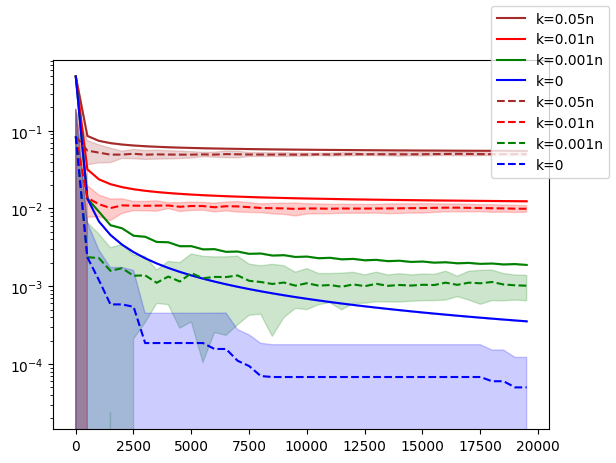

In [20]:
fig, ax = plt.subplots()

plotCIs(ns, kprop05_epsilons_byn_bychunk, "k=0.05n", ax, 'brown')
plotCIs(ns, kprop01_epsilons_byn_bychunk, "k=0.01n", ax, 'red')
plotCIs(ns, kprop001_epsilons_byn_bychunk, "k=0.001n", ax, 'green')
plotCIs(ns, kprop0_epsilons_byn_bychunk, "k=0", ax, 'blue')

plotCIs(ns, kprop05_empiricalEpsilons_byn_bychunks, "k=0.05n", ax, 'brown', linestyle="dashed")
plotCIs(ns, kprop01_empiricalEpsilons_byn_bychunks, "k=0.01n", ax, 'red', linestyle="dashed")
plotCIs(ns, kprop001_empiricalEpsilons_byn_bychunks, "k=0.001n", ax, 'green', linestyle="dashed")
plotCIs(ns, kprop0_empiricalEpsilons_byn_bychunks, "k=0", ax, 'blue', linestyle="dashed")

fig.legend()
plt.yscale("log")

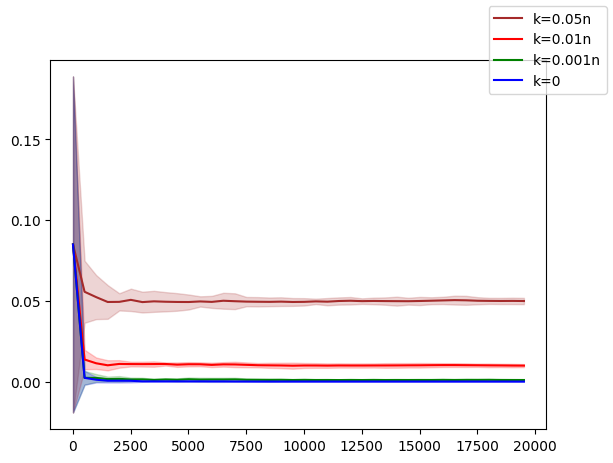

In [21]:
fig, ax = plt.subplots()

plotCIs(ns, kprop05_empiricalEpsilons_byn_bychunks, "k=0.05n", ax, 'brown')
plotCIs(ns, kprop01_empiricalEpsilons_byn_bychunks, "k=0.01n", ax, 'red')
plotCIs(ns, kprop001_empiricalEpsilons_byn_bychunks, "k=0.001n", ax, 'green')
plotCIs(ns, kprop0_empiricalEpsilons_byn_bychunks, "k=0", ax, 'blue')

fig.legend()

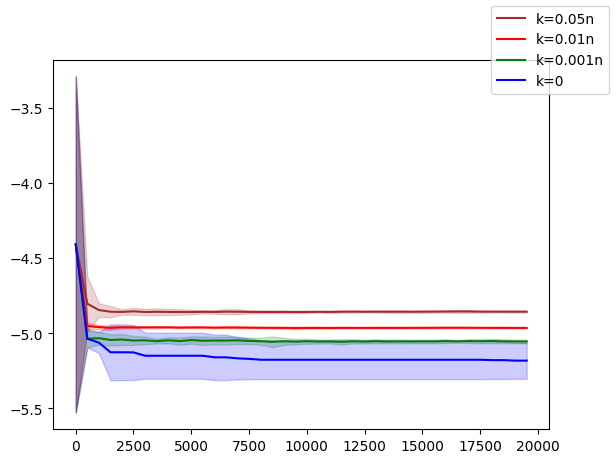

In [22]:
fig, ax = plt.subplots()

plotCIs(ns, kprop05_guarantees_byn_bychunk, "k=0.05n", ax, 'brown')
plotCIs(ns, kprop01_guarantees_byn_bychunk, "k=0.01n", ax, 'red')
plotCIs(ns, kprop001_guarantees_byn_bychunk, "k=0.001n", ax, 'green')
plotCIs(ns, kprop0_guarantees_byn_bychunk, "k=0", ax, 'blue')

fig.legend()

interesting that the blue for robust doesnt seem to have stabilised by 20k; all the othbers inc blue for nonrobust have stablised by this point. this sorta makes sense tho, the robust one is much better with the worst returns so while the non robuist one bottoms out quikck, it takes a while for the robus policy to make bad enough decisions to push the min that far down!

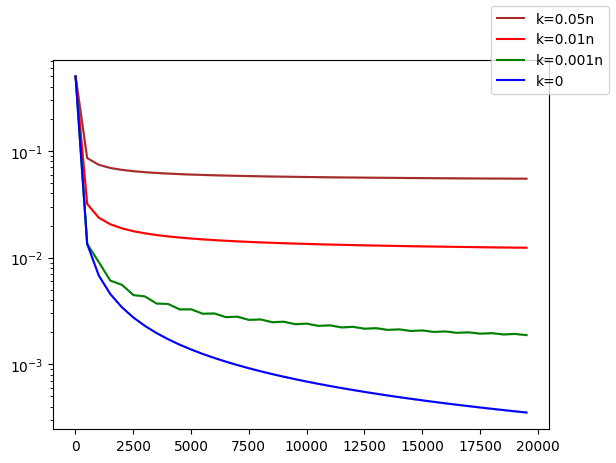

In [39]:
fig, ax = plt.subplots()

plotCIs(ns, kprop05_epsilons_byn_bychunk, "k=0.05n", ax, 'brown')
plotCIs(ns, kprop01_epsilons_byn_bychunk, "k=0.01n", ax, 'red')
plotCIs(ns, kprop001_epsilons_byn_bychunk, "k=0.001n", ax, 'green')
plotCIs(ns, kprop0_epsilons_byn_bychunk, "k=0", ax, 'blue')

fig.legend()
plt.yscale("log")

These plots are interesting, esp for the non robust one where for largher k, the guarnatees very much start low and go UP before stablising, nice. Would be intersting to find the truye risk values for the given guarantees, perhapos plot dotted in the epsilon plots? with the same colours ofc!

^ could find the risk values for each of the 5 guarantees (at each given timepoint) and then plot the confidence interfals for risk on the above plot with dotted lines :) neat!

Theorem 2 c2

In [9]:
a=-1-3*(1)
b=5/env.unwrapped.normalize_rewards + 1 + env.unwrapped.bridge_bonus_factor*env.unwrapped.exp_bonus
print(f"(a,b) = {(a,b)}")

(a,b) = (-4, 3.15625)


In [12]:
eta = 0.9
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (-0.6,0.2)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))




  0%|          | 0/101 [00:00<?, ?it/s]

C:\Users\fabia\Documents\GitHub\MetaStableBaselines3\proj_code\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:552: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  epsilon = fsolve(self._theorem2_epsiloneq, starting_point, args=(k,K,n,gamma,eta))
100%|██████████| 101/101 [01:00<00:00,  1.66it/s]

(array([0.01273097]), np.float64(-0.2054250631712344))


In [13]:
eta = 0.9
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (a,b)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))

100%|██████████| 101/101 [01:15<00:00,  1.35it/s]

(array([0.01273097]), np.float64(-1.5694547186314007))


In [14]:
eta = 0.01
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (-0.6,0.2)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))

  0%|          | 0/101 [00:00<?, ?it/s]C:\Users\fabia\Documents\GitHub\MetaStableBaselines3\proj_code\stable-baselines3-master\stable-baselines3-master\stable_baselines3\common\on_policy_algorithm.py:552: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  epsilon = fsolve(self._theorem2_epsiloneq, starting_point, args=(k,K,n,gamma,eta))
 96%|█████████▌| 97/101 [01:20<00:03,  1.20it/s]

(array([0.1171632]), np.float64(-0.2054250631712344))


In [15]:
eta = 0.01
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0

epsilon, guarantee =  meta_agent.task_risk_SMC_c2(gamma, eta, k, returns, (a,b)) #TODO: intereswtingly too conservative bounds here may make c3 better!
print((epsilon, guarantee))

 96%|█████████▌| 97/101 [01:06<00:02,  1.46it/s]

(array([0.1171632]), np.float64(-1.5694547186314007))


Theorem 2 c3

In [16]:
eta = 0.9
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0



epsilon, guarantee =  meta_agent.task_risk_SMC_c3(gamma, eta, k, [i[0] for i in return_list_sorted], returns)
print((epsilon, guarantee))

gamma_2=0.022512147630450167


100%|██████████| 101/101 [01:05<00:00,  1.55it/s]

(array([0.02632269]), tensor(-0.1911))


In [17]:
eta = 0.01
gamma = 0.01 #small to be pretty confient in our bounds (therefore they will be pretty poor guarantees i suppose? hopefully that is what should happen -big t!)
k=0



epsilon, guarantee =  meta_agent.task_risk_SMC_c3(gamma, eta, k, [i[0] for i in return_list_sorted], returns)
print((epsilon, guarantee))

gamma_2=0.022512147630450167


 94%|█████████▍| 95/101 [00:50<00:03,  1.88it/s]

(array([0.15606601]), tensor(-0.1911))
